<a href="https://colab.research.google.com/github/PSX-Ramitas/CSCI-166/blob/main/166_ArmSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Pybullet Simulation Software

We are using pybullet for our simulation softwar this needs to donloaded to use in collab.

In [1]:
pip install -U pybullet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 19.4 MB/s eta 0:00:00


Next we do all the imports this includes things from pybullet as well as the pytorch libraries.

In [2]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pybullet as p
import time
import pybullet_data
import os
from datetime import datetime

Next we mount google drive to load in stuff for the simulation as well as save our data and models.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create a class for the simulations

This class will handle all the back end for the simulation form simply getting it started to loading up all the assets.  It also handles what to do in the case of collisions and gives the rewards for each session.  The actual simulation situation was designed and implimented by our team with pybullet just being used as a physics engine.

We modeled the arm in blender and defined how it could behave in a urdf file.  We also implemented the reward scheme for the robots behavior.

In [4]:
class ArmEnv:
    def __init__(self, gui=True, mSteps=500):
        # initialize variables
        self.gui = gui
        self.physics_client = None
        self.planeId = None
        self.armId = None
        self.cubeId = None
        self.Tray = None
        self.stepSize = 0.00872665
        self.actionSpace = 729
        self.cubeStartPos = [0.1, 0.15, 0.05]
        self.trayStartPos = [-0.05, 0.2, 0.01]
        self.endPoint = self.trayStartPos.copy()
        self.endPoint[2] += 0.2

        # set up variables for camera
        self.cameraYawId = 17
        self.cameraPitchId = 18
        self.cameraYaw = -0.3
        self.cameraPitch = -0.8

        # an array of servo Ids
        # goes from base upward
        # last two are right claw and left claw
        self.ServoIds = [2, 3, 4, 7, 9, 13, 15]

        # array for servo angles
        # corresponds to servo ids
        self.ServoAngles = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

        # variables to keep track of updates
        self.reward = 0
        self.phase = 0
        self.state = None
        self.padTouch = False
        self.finished = False
        self.CubeTouchTray = False
        self.CubeTouchFloor = False
        self.steps = 0
        self.maxSteps = mSteps

    def connect(self):
        mode = p.GUI if self.gui else p.DIRECT
        self.physics_client = p.connect(mode)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        print("connected to pybullet simulation")

    def disconnect(self):
        # diconnect form the simulation
        if self.physics_client is not None:
            p.disconnect()
            self.physics_client = None
            self.planeId = None
            self.armId = None
            print("diconnected from pybullet simulation")

    def load_environment(self):
        # Set the initial conditions of the simulation
        p.setGravity(0,0,-9.8)
        self.planeId = p.loadURDF("plane.urdf")
        startPos = [0,0,0.01]
        startOrientation = p.getQuaternionFromEuler([0,0,0])
        self.armId = p.loadURDF("/content/drive/MyDrive/166_Project/ArmObj/Robot_Arm.urdf", startPos, startOrientation, useFixedBase=True)
        self.cubeId = p.loadURDF("/content/drive/MyDrive/166_Project/ArmObj/Cube.urdf", self.cubeStartPos)
        self.TrayId = p.loadURDF("/content/drive/MyDrive/166_Project/ArmObj/Tray.urdf", self.trayStartPos)

        # Get the total number of joints (which is also the number of child links)
        num_joints = p.getNumJoints(self.armId)


        # Enable collisions between all links of the same object
        for joint_index in range(num_joints):
            # Setting collision filter to allow self-collision (i.e., link with itself)
            p.setCollisionFilterGroupMask(self.armId, joint_index, -1, -1)  # Enable self-collision for all links

        # Set the joint angle (position control mode)
        # move camera yaw to correct position
        p.setJointMotorControl2(
            self.armId,             # Robot ID
            self.cameraYawId,            # Joint index
            controlMode=p.POSITION_CONTROL,  # Position control mode
            targetPosition=self.cameraYaw,    # Target joint angle in radians
            force=500            # Maximum force to apply
        )

        # move camera pitch to correct position
        p.setJointMotorControl2(
            self.armId,             # Robot ID
            self.cameraPitchId,            # Joint index
            controlMode=p.POSITION_CONTROL,  # Position control mode
            targetPosition=self.cameraPitch,    # Target joint angle in radians
            force=500            # Maximum force to apply
        )

        for i in range(50):
            self.step()

    def resetSim(self):
        if self.physics_client is not None:
            p.resetSimulation()

            # array for servo angles
            # corresponds to servo ids
            self.ServoAngles = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

            # variables to keep track of updates
            self.reward = 0
            self.phase = 0
            self.state = None
            self.padTouch = False
            self.finished = False
            self.CubeTouchTray = False
            self.CubeTouchFloor = False
            self.steps = 0

            self.load_environment()

            rgb_image = self.getCameraImage()

            # Convert the image from RGBA (4 channels) to RGB (3 channels)
            rgb_image = rgb_image[:, :, :3]

            self.state = [rgb_image, self.ServoAngles]

        return self.state

    def setMotorsPosition(self):
        # set default servo joint states

        for i in range(7):
            # move camera pitch to correct position
            p.setJointMotorControl2(
                self.armId,             # Robot ID
                self.ServoIds[i],            # Joint index
                controlMode=p.POSITION_CONTROL,  # Position control mode
                targetPosition=self.ServoAngles[i],    # Target joint angle in radians
                force=100,            # Maximum force to apply
                positionGain=1,  # Increase stiffness
                velocityGain=1   # Increase damping
            )

    def setMotorVelocity(self):
        # set default servo joint states

        for i in range(7):
            # move camera pitch to correct position
            p.setJointMotorControl2(
                self.armId,             # Robot ID
                self.ServoIds[i],            # Joint index
                controlMode=p.VELOCITY_CONTROL,  # Position control mode
                targetVelocity=0,
                force=10,            # Maximum force to apply
            )

    def updateServo(self, action: int, servo: int):
        # if action is 1 then move by positive tenth of a degree
        if (action == 1):
            self.ServoAngles[servo] -= self.stepSize
            if (self.ServoAngles[servo] <= -1.57):  # check if went beyond limits
                self.reward -= 10
                return False

        # if action is 2 then move by a negative tenth of a degree
        elif (action == 2):
            self.ServoAngles[servo] += self.stepSize
            if (self.ServoAngles[servo] >= 1.57): #check if went beyond limits
                self.reward -= 10
                return False

        return True

    def updateClawsServo(self, action: int):
        # if action is 1 then move by positive tenth of a degree
        if (action == 1):
            self.ServoAngles[5] += self.stepSize
            self.ServoAngles[6] -= self.stepSize
            if (self.ServoAngles[5] >= 0):  # check if went beyond limits
                self.reward -= 10
                return False

        # if action is 2 then move by a negative tenth of a degree
        elif (action == 2):
            self.ServoAngles[5] -= self.stepSize
            self.ServoAngles[6] += self.stepSize
            if (self.ServoAngles[5] <= -0.785398): #check if went beyond limits
                self.reward -= 10
                return False

        return True

    def collisionCheck(self):
        contact_points = p.getContactPoints()
        self.padTouch = False

        for contact in contact_points:
            # if contact is with the ground
            if contact[1] == self.planeId:
                # if contact is with robot
                if contact[2] == self.armId:
                    # check that contact is not with the base
                    if contact[4] != -1:
                      self.reward -= 10
                      return False

                # check if contact is with the cube
                # also check what phase it is, only matter if in phase 3
                # to not let cube drag on floor
                elif contact[2] == self.cubeId:
                    self.CubeTouchFloor = True

            # check if it is the robot contacting something else
            # also contact will not be with ground since that would appear first
            elif contact[1] == self.armId:
                # make sure it is the cube that is being touched
                if contact[2] == self.cubeId:
                    # if the contact is not with the touch pad, if so return false and have penalty
                    if contact[3] != 14 and contact[3] != 15:
                        self.reward -= 10
                        return False
                    # if it is both touch pad touching the cube then set flag to true
                    elif contact[3] == 14 and contact[3] == 15:
                        self.padTouch = True
                else:
                    self.reward -= 10
                    return False

            elif contact[1] == self.cubeId:
                if contact[2] == self.TrayId:
                    if contact[4] == -1:
                        self.CubeTouchTray = True


        return True


    def takeAction(self, action: int):
        self.reward = 0
        self.steps += 1

        prev_pos = self.ServoAngles.copy()
        control = self.convInttoBase3(action)
        take_step = True
        pos_ClawL = np.array(p.getLinkState(self.armId, 14)[0])
        pos_ClawR = np.array(p.getLinkState(self.armId, 15)[0])
        prev_cube = p.getBasePositionAndOrientation(self.cubeId)

        prev_pos_C = ((pos_ClawL - pos_ClawR) * 0.5) + pos_ClawR

        # loop through the servos updating positions
        for i in range(5):
            take_step = (take_step and self.updateServo(control[i], i))

        # update claw seperately since it is two joints in simulation but one servo in real world
        take_step = (take_step and self.updateClawsServo(control[5]))

        if take_step:
            # run simulation for a moment to let arm update itself
            # check for collisions then and penalise for them
            for i in range(5):
                self.step()
                take_step = (take_step and self.collisionCheck())
                if not take_step:
                    break

            # if there is a collision don't do this and simply back step

            if take_step:
                pos1 = np.array(p.getLinkState(self.armId, 14)[0])
                pos2 = np.array(p.getLinkState(self.armId, 15)[0])

                posC = ((pos1 - pos2) * 0.5) + pos2

                cube, _ = p.getBasePositionAndOrientation(self.cubeId)

                dist1 = math.dist(cube, prev_pos_C)
                dist2 = math.dist(cube, posC)

                if self.phase == 0:
                    prev_dist = abs(0.3 - prev_pos[6])
                    dist = abs(0.3 - self.ServoAngles[6])
                    if prev_dist > dist:
                        self.reward += 1
                    elif prev_dist < dist:
                        self.reward -= 1

                    if dist1 > dist2:
                        self.reward += 2
                    elif dist1 < dist2:
                        self.reward -= 2

                    if dist2 < 0.02:
                        self.phase = 1
                        self.reward += 20

                elif self.phase == 1:
                    prev_dist = abs(0.3 - prev_pos[6])
                    dist = abs(0.3 - self.ServoAngles[6])
                    if prev_dist < dist:
                        self.reward += 1
                    elif prev_dist > dist:
                        self.reward -= 1

                    if dist1 > dist2:
                        self.reward += 1
                    elif dist1 < dist2:
                        self.reward -= 1

                    if dist2 > 0.03:
                        self.phase = 1
                        self.reward -= 10

                    if self.padTouch:
                        self.phase = 2

                elif self.phase == 2:

                    if dist2 > dist1:
                        self.reward -= 1

                    if self.CubeTouchFloor:
                        self.reward -= 1

                    if dist2 > 0.03:
                        self.phase = 1
                        self.reward -= 10

                    dist3 = math.dist(cube, self.endPoint)
                    if dist3 < 0.02:
                        self.reward += 20
                        self.phase = 3

                elif self.phase == 3:
                    prev_dist = abs(0.3 - prev_pos[6])
                    dist = abs(0.3 - self.ServoAngles[6])
                    if prev_dist > dist:
                        self.reward += 1
                    elif prev_dist < dist:
                        self.reward -= 1

                    if dist2 > 0.03 and self.CubeTouchFloor:
                        self.phase = 1
                        self.reward -= 10

                    tray, _ = p.getBasePositionAndOrientation(self.TrayId)
                    dist4 = math.dist(cube, tray)
                    dist5 = math.dist(prev_cube, tray)
                    if dist4 < dist5:
                        self.reward += 1

                    if self.CubeTouchTray:
                        self.reward += 100
                        self.finished = True

            else:
                self.ServoAngles = prev_pos

        else:
            self.ServoAngles = prev_pos

        self.CubeTouchFloor = False

        rgb_image = self.getCameraImage()

        # Convert the image from RGBA (4 channels) to RGB (3 channels)
        rgb_image = rgb_image[:, :, :3]

        observation = [rgb_image, self.ServoAngles]

        return observation, self.reward, self.finished


    def step(self):
        self.setMotorsPosition()
        p.stepSimulation()

    def getCameraImage(self):
        # get position and orientation of the link representing physical camera
        camera_position, camera_orientation,_,_,_,_  = p.getLinkState(self.armId, 19)

        # set camera offset so it is not in the link
        camera_offset = [0, 0.015, 0]

        # Calculate the camera's eye position by adding the offset to the robot's position
        eye_position = [camera_position[0] + camera_offset[0],
                        camera_position[1] + camera_offset[1],
                        camera_position[2] + camera_offset[2]]

        # increase the offset a bit so it is looking ahead
        camera_offset = [0, 1, 0]

        camera_orientation = p.getEulerFromQuaternion(camera_orientation)
        Roll  = camera_orientation[1] * (180.0 / math.pi)
        Pitch = camera_orientation[0] * (180.0 / math.pi)
        Yaw   = camera_orientation[2] * (180.0 / math.pi)

        # Compute the view matrix (camera's position and orientation)
        view_matrix = p.computeViewMatrixFromYawPitchRoll(eye_position,
                                                          distance=0.1,
                                                          yaw=Yaw,
                                                          pitch=Pitch,
                                                          roll=Roll,
                                                          upAxisIndex=2)

        # Define the projection matrix (field of view, aspect ratio, near/far planes)
        fov = 60  # Field of view in degrees
        aspect_ratio = 1.0  # Aspect ratio (width/height of the output image)
        near_plane = 0.1  # Near clipping plane distance
        far_plane = 100  # Far clipping plane distance

        projection_matrix = p.computeProjectionMatrixFOV(fov, aspect_ratio, near_plane, far_plane)

        # Capture the image from the camera's viewpoint
        width = 480
        height = 270
        image = p.getCameraImage(width, height, view_matrix, projection_matrix)

        return np.array(image[2])  # Return the RGB image (height x width x 4)

    def convInttoBase3(self, x: int):
        out = [0,0,0,0,0,0]
        if x > 0 and x < 730:
            j = 5
            for i in range(6):
                out[j] = x % 3
                x = x // 3
                j -= 1
        return out

    def setEndPoint(self):
        self.endPoint, _ = p.getBasePositionAndOrientation(self.TrayId)
        self.endPoint[2] += 0.2

    def __del__(self):
        # ensure that simulation is ended on death of object
        if self.physics_client is not None:
            p.disconnect()

# initialize instance of simulation
env = ArmEnv(False)

This next block simply ensures that pybullet is connected correctly.

connected to pybullet simulation


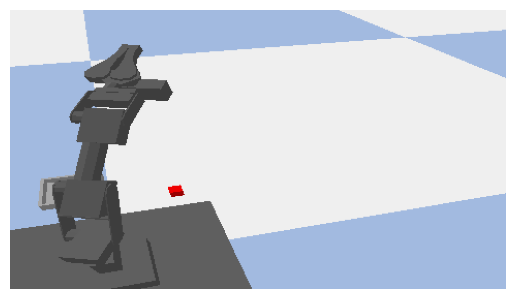

diconnected from pybullet simulation


In [5]:
#testing will be removed on final implementation
env.connect()
env.load_environment()

env.resetSim()

obj = []

for i in range(50):

    observation, reward, terminated = env.takeAction(360)

    #print(f"observation shape: {observation[0].shape}, {observation[1].shape}")
    #print(f"reward: {reward}")
    #print(f"terminated: {terminated}")

    obj = observation[0]

    time.sleep(1./240.)

# Display the image using Matplotlib
plt.imshow(obj)
plt.axis('off')  # Hide axes for better visualization
plt.show()

env.disconnect()

# Replay Memory

Next we define an object to hold the replay memory as well as a class to hold each memory and keep it to a certain size.

In [6]:
# the transition model/states
Transition = namedtuple('Transition', ('state1', 'state2', 'action', 'next_state1', 'next_state2', 'reward'))

# class to hold the replay memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Define the Network Architecture

This is where we define the actual shape of the network we are going to use from the number of layers to how each of those layers behave.

Our network is composed of 7 layers with the first 3 being convolutional and the last 4 being fully connected.  The first 3 handle the camera data to find usefull features and help shrink it down to be handleable by the fully connected layers.  When the camera data is flattened it is also concatenated with some other data, the servo angles, then it is passed through 4 fully connected layers to eventually have an output of 729 units.

In [7]:
# create a class for the nueral network model
class ArmDQN(nn.Module):

    def __init__(self, n_actions):
        super(ArmDQN, self).__init__()
        # first layer goes from 3 input channels to 6 output channels
        self.layer1 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        # second layer has 6 input channels and goes to 3 output channels
        self.layer2 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        # second layer has 6 input channels and goes to 3 output channels
        self.layer3 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        # layer for switching to fully connected linear network
        # is set to none since input must be set dynamically based on the convolutional network
        # the input amount is correct for initial input of size [ 3, 480, 270]
        self.fc1 = nn.Linear(5947, 5832)
        # second linear layer
        self.fc2 = nn.Linear(5832, 2916)
        # third linear layer
        self.fc3 = nn.Linear(2916, 1458)
        # fourth linear layer
        self.fc4 = nn.Linear(1458, n_actions)


    def forward(self, x, y):
        x = self.layer1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.flatten(1)
        x = torch.cat((x, y), dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        # x = F.relu(x)
        return x

# Defining Hyperparameters

Next we define our hyperparameters for the model


*   Batch_Size - defines how large of a batch to use when optimizing the policy
*   Gamma - determines the weight of time on the aproximation of values
*   Epsilon - this determines how much the model should explore vs. exploit.  It is composed of 3 parts the start the end and the decay the start and end define the limits and the decay defines how many steps it takes to get to the end.
*   Tau - controls the influence of the policy_network vs target_network weights on updating the target_network
*   Learning Rate - controls how much to update the weights of the policy network when doing backpropagation
*   Memory Size - controls the capacity of the Replay memory
*   Max Episode Duration - controls the maximum amount of steps that can be spent in one episode



In [8]:
# setup which device to use
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)


# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-5
MEMORYSIZE = 4000
MAXEPISODEDURATION = 100

if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 100
else:
    num_episodes = 1

# Initialize the Networks

Next we setup variables to hold data we use to record the results of training.

* episode_durations - how long on each episode was spent
* total_rewards - what was the total cumulative reward for an episode
* max_phase - what was the maximum phase reached in an episode
* end_phase - what was the phase the episode ended on
* time_per_phase - how much time of the episode was spent in each phase

This is also where both the policy and the target networks are initialized and there initial states set equal to each other.

In [9]:
# number of actions
n_actions = env.actionSpace

# variables for recording
# list of episode lengths
episode_durations = []
# list of total rewards
total_rewards = []
# list of max phase
max_phase = []
end_phase = []
# list of time per phase
time_per_phase = []

policy_net = ArmDQN(n_actions).to(device)
target_net = ArmDQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(MEMORYSIZE)

steps_done = [0, 0, 0, 0]


# Select Action Function

This function selectes the next action to take with epsilon greedy algorithm.
This allows the model to explore by taking random steps and eventually following the model more and more.

In [10]:
# select which action to take next
# either us the policy_net output or get rand action
def select_action(state1, state2, phase):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done[phase]/ EPS_DECAY)
    steps_done[phase] += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state1, state2).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randint(0, (n_actions - 1))]], device=device, dtype=torch.long)

# Optimize Model Function

This function is where the policy network is optimized.  A batch is called from the replay memory and used to updat the policy network using results from the target network which is soft updated at each step.

In [11]:
def optimize_model():
    # check if enouch action state pairs in memory
    if len(memory) < BATCH_SIZE:
        return

    # get a sample from memory of batch size
    transitions = memory.sample(BATCH_SIZE)

    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state1)), device=device, dtype=torch.bool)
    non_final_next_states1 = torch.cat([s for s in batch.next_state1 if s is not None])
    non_final_next_states2 = torch.cat([s for s in batch.next_state2 if s is not None])
    state1_batch = torch.cat(batch.state1)
    state2_batch = torch.cat(batch.state2)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) with the model
    # these are the actions which would've been taken for each batch state according to policy
    state_action_values = policy_net(state1_batch, state2_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states1, non_final_next_states2).max(1).values

    #Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Hubber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# Run Model

In this last step the model is run taking actions in the simulated environment and getting fead back to train with based on the results.

In [12]:
env.connect()
# env.load_environment()

for i_episodes in range(num_episodes):
    # append total reward with 0 and add two it each step of the episode
    total_rewards.append(0)
    time_per_phase.append([0,0,0,0])
    max_phase.append(0)

    state1, state2 = env.resetSim()
    state1 = torch.tensor(state1, dtype=torch.float32, device=device).unsqueeze(0)
    state1 = state1.permute(0, 3, 2, 1)
    state2 = torch.tensor(state2, dtype=torch.float32, device=device).unsqueeze(0)

    print(f"Episode: {i_episodes}")

    for t in count():
        prev_phase = env.phase

        action = select_action(state1, state2, env.phase)
        observation, reward, terminated = env.takeAction(action.item())
        total_rewards[i_episodes] += reward
        reward = torch.tensor([reward], device=device)

        if terminated:
          next_state1 = None
          next_state2 = None
        else:
          next_state1 = torch.tensor(observation[0], dtype=torch.float32, device=device).unsqueeze(0)
          next_state1 = next_state1.permute(0, 3, 2, 1)
          next_state2 = torch.tensor(observation[1], dtype=torch.float32, device=device).unsqueeze(0)

        # store transition in memory
        memory.push(state1, state2, action, next_state1, next_state2, reward)

        # move to next state
        state1 = next_state1
        state2 = next_state2

        # optimize the model
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if prev_phase != env.phase:
            time_per_phase[i_episodes][prev_phase] += t + 1

        if prev_phase < env.phase:
            max_phase[i_episodes] = env.phase

        if terminated or t > MAXEPISODEDURATION:
            episode_durations.append(t + 1)
            end_phase.append(env.phase)
            time_per_phase[i_episodes][env.phase] = t + 1

            print(f"Total Reward: {total_rewards[i_episodes]}")
            print(f"Episode Duration: {t + 1}")
            print(f"Max Phase: {max_phase[i_episodes]}")
            print(f"End Phase: {end_phase[i_episodes]}")
            print(f"Time Per Phase: {time_per_phase[i_episodes]}")
            print("")

            break


year = datetime.today()
time = datetime.now().time()
testId = "NoNegativeReward"

formatted_year = year.strftime("%Y-%m-%d")
formatted_time = time.strftime("%H:%M:%S")

directory = "/content/drive/MyDrive/166_Project/Models/" + formatted_year
if not os.path.exists(directory):
    os.mkdir(directory)

model_path = directory + "/" + testId + "_" + formatted_time + ".pth"

torch.save(policy_net.state_dict(), model_path)

directory = "/content/drive/MyDrive/166_Project/Results/" + formatted_year
if not os.path.exists(directory):
    os.mkdir(directory)

testInfo_path = directory + "/" + testId + "_" + formatted_time + ".csv"

with open(testInfo_path, "w") as file:
    file.write("Test Information for " + testId)

with open(testInfo_path, "a") as file:
    file.write("\nnum_episodes, batch_size, Gamma, Eps_start, Eps_end, Eps_decay, Tau, Learning_rate, memory_size, max_episode_duration")
    file.write(f"\n{num_episodes}, {BATCH_SIZE}, {GAMMA}, {EPS_START}, {EPS_END}, {EPS_DECAY}, {TAU}, {LR}, {MEMORYSIZE}, {MAXEPISODEDURATION}")
    file.write("\nepisode, total_rewards, duration, max_phase, end_phase, time_in_phase1, time_in_phase2, time_in_phase3, time_in_phase4")
    for i in range(num_episodes):
        file.write(f"\n{i}, {total_rewards[i]}, {episode_durations[i]}, {max_phase[i]}, {end_phase[i]}, {time_per_phase[i][0]}, {time_per_phase[i][1]}, {time_per_phase[i][2]}, {time_per_phase[i][3]}")

env.disconnect()

connected to pybullet simulation
Episode: 0
Total Reward: -5
Episode Duration: 102
Max Phase: 0
End Phase: 0
Time Per Phase: [102, 0, 0, 0]

Episode: 1
Total Reward: -43
Episode Duration: 102
Max Phase: 0
End Phase: 0
Time Per Phase: [102, 0, 0, 0]

Episode: 2
Total Reward: -25
Episode Duration: 102
Max Phase: 0
End Phase: 0
Time Per Phase: [102, 0, 0, 0]

Episode: 3
Total Reward: 11
Episode Duration: 102
Max Phase: 0
End Phase: 0
Time Per Phase: [102, 0, 0, 0]

Episode: 4
Total Reward: -80
Episode Duration: 102
Max Phase: 0
End Phase: 0
Time Per Phase: [102, 0, 0, 0]

Episode: 5
Total Reward: -18
Episode Duration: 102
Max Phase: 0
End Phase: 0
Time Per Phase: [102, 0, 0, 0]

Episode: 6
Total Reward: -93
Episode Duration: 102
Max Phase: 0
End Phase: 0
Time Per Phase: [102, 0, 0, 0]

Episode: 7
Total Reward: -8
Episode Duration: 102
Max Phase: 0
End Phase: 0
Time Per Phase: [102, 0, 0, 0]

Episode: 8
Total Reward: -31
Episode Duration: 102
Max Phase: 0
End Phase: 0
Time Per Phase: [102,